# Source Sink Algorithm Validation Algorithm - Interictal Data



# Disc

Hypothesis: All indices should be higher in SOZ vs SOZ^C.

source_infl, sink_conn, sink_ind all from A matrix, but not directly from each other
ss_ind = source_infl * sink_conn * sink_ind

Exps:
- source_infl -> quantile vectors -> RF -> cv
- sink_conn -> ''
- sink_ind -> ''
- source_infl, sink_conn, sink_ind -> quantile vectors -> RF -> cv
- ^ repeat the above 4, but instead take E[A] first, and the average A -> source_infl (vector) -> quantile

Note: ss_ind = combination of all three, so no need to add

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    ShuffleSplit,
    cross_validate,
)
from sklearn.utils import resample

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from rerf.rerfClassifier import rerfClassifier
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [4]:
class MatReader:
    """
    Object to read mat files into a nested dictionary if need be.
    Helps keep strucutre from matlab similar to what is used in python.
    """

    def __init__(self, filename=None):
        self.filename = filename

    def loadmat(self, filename):
        """
        this function should be called instead of direct spio.loadmat
        as it cures the problem of not properly recovering python dictionaries
        from mat files. It calls the function check keys to cure all entries
        which are still mat-objects
        """
        try:
            data = scipy.io.loadmat(
                filename, struct_as_record=False, squeeze_me=True, chars_as_strings=True
            )
        except NotImplementedError as e:
            print(e)
            data = hdf5storage.loadmat(filename)
        return self._check_keys(data)

    def _check_keys(self, dict):
        """
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in dict:
            if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
                dict[key] = self._todict(dict[key])
        return dict

    def _todict(self, matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        dict = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                dict[strg] = self._todict(elem)
            elif isinstance(elem, np.ndarray):
                dict[strg] = self._tolist(elem)
            else:
                dict[strg] = elem
        return dict

    def _tolist(self, ndarray):
        """
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
                elem_list.append(self._todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(self._tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list

In [5]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        # get the index of the subject
        if subject != desired_subject:
            continue

        # get the metadata
        soz_chs = dataset["soz_chs"][idx]
        ch_names = dataset["ch_names"][idx]
        soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
        nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

        # get the data
        feature_map = dataset[feature_name][idx]

        # stratify data into two sets of signals
        soz_feat = feature_map[soz_inds, :]
        nsoz_feat = feature_map[nsoz_inds, :]

        x = np.arange(soz_feat.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()
        #     plt.tick_params(labelsize=14)
        y_mean = soz_feat.mean(axis=0)
        y_sem = scipy.stats.sem(soz_feat, axis=0)
        ax.plot(x, y_mean, label="soz", color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        y_mean = nsoz_feat.mean(axis=0)
        y_sem = scipy.stats.sem(nsoz_feat, axis=0)
        ax.plot(x, y_mean, label="soz^c", color="black")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="black", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
            #         font_size=20,
        )
        ax.legend()
        break

# Setup Data Directory

In [6]:
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "presurgery"
task = "interictal"
acquisition = "seeg"  # note not all subjects are actually sEEG
reference = "car"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"

deriv_path = deriv_root / deriv_chain

In [7]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

In [8]:
subjects = natsorted(get_entity_vals(deriv_path, "subject"))
print(subjects)

['002', '003', '004', '005', '006', '009', '011', '013', '014', '015', 'NIH1', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'PY18N002', 'PY18N013', 'PY18N015', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N026', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl02', 'nl04', 'nl05', 'nl06', 'nl07', 'nl08', 'nl11', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt9', 'pt10', 'pt11', 'pt12', 'pt13', 'upmc1', 'upmc2', 'upmc3', 'upmc5', 'upmc6']


In [9]:
# subjects given by Kristin/Group to use
subjects_str = (
    "la02, la03, la04, la05, la06, la08, la09, la10, la11, la13, la15, la16, la21, la22, la23, la24, nl01, nl04, nl05, nl07, nl08, nl12, nl13, nl14, nl15, nl16, nl18, nl19, "
    "nl20, pt1, pt3, pt4, pt6, pt8, pt10, pt11, pt12, pt13, PY18N002, PY18N013, PY18N015, PY19N015, PY19N023, 002, 003, 004, 006, 009, 011, 013, 015, NIH2, NIH3, NIH4, NIH5, NIH7, NIH8, "
    "NIH9, NIH10, NIH11, upmc1, upmc2, upmc3, upmc5, upmc6"
)
print([sub for sub in subjects if sub not in subjects_str])
subjects = subjects_str.split(", ")
print(subjects)

['005', '014', 'PY19N012', 'PY19N026', 'la01', 'la07', 'nl02', 'nl06', 'nl11', 'pt2', 'pt5', 'pt7', 'pt9']
['la02', 'la03', 'la04', 'la05', 'la06', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl04', 'nl05', 'nl07', 'nl08', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt3', 'pt4', 'pt6', 'pt8', 'pt10', 'pt11', 'pt12', 'pt13', 'PY18N002', 'PY18N013', 'PY18N015', 'PY19N015', 'PY19N023', '002', '003', '004', '006', '009', '011', '013', '015', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'upmc1', 'upmc2', 'upmc3', 'upmc5', 'upmc6']


## Obtain Labels Using Excel Sheet

In [10]:
meta_df = pd.read_excel(meta_fpath)

display(meta_df.head(2))

,org_patientid,patient_id,number_datasets,clinical_center,modality,sfreq,previous_surgery?,clinical_complexity,engel_score,ilae_score,...,mri_outcome,postop_progress_info,date_of_recording,date_of_surgery,date_of_last_follow_up,years_follow_up,engel_class_full,notes,Unnamed: 38,Unnamed: 39
0,NaN,la01,1,cc,seeg,1000,"Y (SEEG implant 4/2013, craniotomy 4/2013)",4,4,4.0,...,Normal,Seizure free since surgery.,2013-04-10 02:11:44,2014-01-01 00:00:00,2019-10-01 00:00:00,5,NaN,NaN,NaN,NaN
1,NaN,la02,1,cc,seeg,1000,VNS implant 4/24/2014,1,1,1.0,...,Normal,Seizure free since surgery.,NaN,2015-02-01 00:00:00,2018-11-01 00:00:00,3,NaN,PPT says: Lesion?,NaN,NaN


# Obtain Source Sink Data From Each File

In [11]:
dataset = collections.defaultdict(list)

for subject in subjects:
    subj_dir = deriv_path / f"sub-{subject}"
    fpaths = subj_dir.glob("*.mat")
    for idx, fpath in enumerate(fpaths):
        data_path = BIDSPath(
            subject=subject,
            session=session,
            task=task,
            acquisition=acquisition,
            run=idx + 1,
            suffix="ss_ind",
            extension=".mat",
            check=False,
        )
        #         print(f"Reading {fpath}")
        reader = MatReader()
        data_dict = reader.loadmat(fpath)

        #         print(data_dict.keys())
        ch_names = data_dict["labels"]
        soz_chs = data_dict["ez_ch"]
        sink_ind = np.array(data_dict["sink_index"])
        source_infl = np.array(data_dict["source_infl"])
        sink_conn = data_dict["sink_conn"]
        ss_ind = data_dict["ss_index"]

        dataset["subject"].append(subject)
        dataset["sink_ind"].append(sink_ind)
        dataset["source_infl"].append(source_infl)
        dataset["sink_conn"].append(sink_conn)
        dataset["ss_ind"].append(ss_ind)
        dataset["ch_names"].append(ch_names)
        dataset["soz_chs"].append(soz_chs)

#         break

#     break

# Define Cross Validation Function

In [12]:
n_splits = 10
train_size = 0.7
random_state = 12345

subject_groups = np.array(subjects)

In [13]:
cv = StratifiedShuffleSplit(
    n_splits=n_splits, train_size=train_size, random_state=random_state
)

# Define Functions to Get XY data

In [14]:
def get_Xy_matrix(dataset, feature_set):
    # create X, y pair for training
    X = []
    y = []
    engels = []
    ilaes = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        # get the metadata
        soz_chs = dataset["soz_chs"][idx]
        ch_names = dataset["ch_names"][idx]
        soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
        nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

        # compute quantiles in each
        qtiles = np.linspace(0.1, 1.0, 10)

        X_buff = []
        for feature_name in feature_set:
            # get the data
            feature_map = dataset[feature_name][idx].copy()

            # set threshold
            if threshold is not None:
                feature_map[feature_map < threshold] = 0.0

            # stratify data into two sets of signals
            soz_feat = feature_map[soz_inds, :]
            nsoz_feat = feature_map[nsoz_inds, :]

            # create a time-varying quantile heatmap
            soz_quant_map = np.vstack(
                [np.quantile(soz_feat, q=q, axis=0) for q in qtiles]
            )
            nsoz_quant_map = np.vstack(
                [np.quantile(nsoz_feat, q=q, axis=0) for q in qtiles]
            )
            new_data_feat = np.vstack(
                (
                    np.mean(soz_feat, axis=0),
                    #                 np.std(soz_feat, axis=0),
                    soz_quant_map,
                    np.mean(nsoz_feat, axis=0),
                    #                 np.std(nsoz_feat, axis=0),
                    nsoz_quant_map,
                )
            )
            new_data_feat = np.mean(new_data_feat, axis=1, keepdims=True)
            X_buff.extend(new_data_feat.tolist())

        # convert buffer to numpy array for feature vector
        X_buff = np.array(X_buff)

        # get metadata
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
        ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]

        if outcome == "NR":
            continue

        X.append(X_buff)
        y.append(outcome)
        engels.append(engel)
        ilaes.append(ilae)
        subjects.append(subject)

    return X, y, subjects

In [15]:
def get_Xy_vector(dataset, feature_set):
    # create X, y pair for training
    X = []
    y = []
    engels = []
    ilaes = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        if subject.startswith("pt"):
            subject = "kumc" + subject.split("pt")[1]
        elif subject.isnumeric():
            subject = "rns" + subject

        # get the metadata
        soz_chs = dataset["soz_chs"][idx]
        ch_names = dataset["ch_names"][idx]
        soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
        nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

        # compute quantiles in each
        qtiles = np.linspace(0.1, 1.0, 3)

        X_buff = []
        for feature_name in feature_set:
            # get the data
            feature_map = dataset[feature_name][idx].copy()

            # set threshold
            if threshold is not None:
                feature_map[feature_map < threshold] = 0.0

            # stratify data into two sets of signals
            soz_feat = feature_map[soz_inds]
            nsoz_feat = feature_map[nsoz_inds]

            # create a time-varying quantile heatmap
            soz_quant_map = np.vstack([np.quantile(soz_feat, q=q) for q in qtiles])
            nsoz_quant_map = np.vstack([np.quantile(nsoz_feat, q=q) for q in qtiles])
            new_data_feat = np.vstack(
                (
                    np.mean(soz_feat),
                    np.std(soz_feat, axis=0),
                    #                     soz_quant_map,
                    #                     np.median(soz_feat),
                    #                     np.median(nsoz_feat),
                    np.mean(nsoz_feat),
                    np.std(nsoz_feat, axis=0),
                    #                     nsoz_quant_map,
                    np.mean(soz_feat) - np.mean(nsoz_feat),
                )
            )
            #             new_data_feat = np.mean(new_data_feat, axis=1, keepdims=True)
            X_buff.extend(new_data_feat.tolist())

        # convert buffer to numpy array for feature vector
        X_buff = np.array(X_buff)

        # get metadata
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
        ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]

        if outcome == "NR":
            continue

        X.append(X_buff)
        y.append(outcome)
        engels.append(engel)
        ilaes.append(ilae)
        subjects.append(subject)

    return X, y, subjects

# Run from here

In [128]:
desired_subject = "la02"
feature_name = "source_infl"

plot_subject_feature_map(dataset, desired_subject, feature_name)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [76]:
X, y, subject = get_Xy_matrix(dataset, feature_name)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Run for averaged A matrices

In [89]:
feature_name = ["source_infl"]

In [30]:
X, y, subject = get_Xy_vector(dataset, feature_name)

NameError: name 'feature_name' is not defined

In [91]:
X = np.array(X).squeeze()
y = np.array(y).squeeze()
subjects = np.array(subjects)
y = enc.fit_transform(y[:, np.newaxis]).squeeze()

print(new_data_feat.shape)
print(X.shape)
print(y.shape)
print(y)

(22, 1)
(76, 22)
(76,)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 1.]


# Run Classification Validation Pipeline

In [65]:
n_features = X.shape[1]
model_params = {
    #     "projection_matrix": "RerF",
    "n_estimators": 500,
    "max_features": n_features * 2,
    "n_jobs": -1,
    "random_state": random_state,
}


# model_params["projection_matrix"] = "S-RerF"
# model_params["image_height"] = 24
# model_params["image_width"] = 30


# clf = rerfClassifier(**model_params)
clf = ObliqueForestClassifier(**model_params)
clf = RandomForestClassifier(**model_params)

In [66]:
# perform CV using Sklearn
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    #     groups=subject_groups,
    #     cv=zip(train_index, test_index),
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
)

In [67]:
# get the estimators
estimators = scores.pop("estimator")

print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_subjects",
    "test_subjects",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]
    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

Using estimator  ObliqueForestClassifier(max_features=44, n_estimators=500, n_jobs=-1,
                        random_state=12345)


In [70]:
fname = deriv_root / f"cv{n_splits}_exp_{feature_name}.pkl"

In [71]:
with open(fname, "wb") as file_name:
    pickle.dump(scores, file_name)
#     json.dump(scores, file_name)

# Concatenation of All Feature Representations

Here, we'll look at combining all features into one concatenated feature set

In [16]:
feature_set = ["sink_ind", "sink_conn", "source_infl"]

## Generate X,y data

## Thoughts on Feature Rep

- std perhaps not as needed
- using the average A matrix -> then feature computation instead (perhaps less noisy)

In LR:
- also took difference between the two average values (i.e. soz_sink - nsoz_sink)

In [17]:
# optional threshold
threshold = None

In [18]:
X, y, subjects = get_Xy_vector(dataset, feature_set)

In [19]:
X = np.array(X).squeeze()
y = np.array(y).squeeze()
subjects = np.array(subjects)
y = enc.fit_transform(y[:, np.newaxis]).squeeze()
print(X.shape)
print(y.shape)
print(y)

(65, 15)
(65,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


In [20]:
for train_inds, test_inds in cv.split(X, y):
    print(subjects[train_inds])

['nl12' 'NIH3' 'nl08' 'NIH9' 'la13' 'PY18N002' 'rns006' 'nl19' 'kumc13'
 'la11' 'nl07' 'kumc4' 'nl20' 'la09' 'kumc1' 'rns013' 'la22' 'kumc3'
 'NIH8' 'NIH4' 'upmc6' 'rns009' 'PY18N015' 'NIH10' 'kumc12' 'la08' 'nl01'
 'la15' 'nl16' 'upmc2' 'la05' 'la06' 'la02' 'kumc11' 'nl04' 'nl15'
 'kumc10' 'rns003' 'la23' 'rns004' 'la10' 'la03' 'la24' 'kumc8' 'NIH7']
['nl07' 'la21' 'PY18N013' 'rns002' 'PY19N023' 'kumc10' 'nl04' 'rns013'
 'NIH3' 'upmc1' 'la10' 'rns015' 'nl16' 'la03' 'NIH10' 'rns006' 'rns009'
 'nl19' 'upmc5' 'la24' 'NIH8' 'la16' 'upmc3' 'NIH7' 'NIH11' 'kumc4' 'nl08'
 'kumc3' 'nl18' 'la08' 'la06' 'NIH4' 'nl15' 'la22' 'la11' 'rns003' 'NIH5'
 'rns011' 'kumc13' 'PY18N002' 'la15' 'kumc8' 'nl14' 'NIH2' 'la23']
['la03' 'PY19N015' 'nl19' 'la06' 'nl16' 'nl01' 'la24' 'nl13' 'upmc1'
 'la16' 'la02' 'la21' 'la11' 'rns002' 'kumc1' 'kumc10' 'rns013' 'kumc12'
 'la08' 'upmc2' 'kumc11' 'NIH10' 'nl15' 'upmc5' 'rns011' 'NIH5' 'NIH11'
 'PY18N002' 'la23' 'nl05' 'NIH4' 'rns003' 'la22' 'la04' 'nl08' 'la09'
 'N

## Define Classification Model and Run cross_validate

In [21]:
n_features = X.shape[1]
model_params = {
    #     "projection_matrix": "RerF",
    "n_estimators": 2000,
    "max_features": 2 * n_features,  # * 2,
    "n_jobs": -1,
    "random_state": random_state,
}
# clf = rerfClassifier(**model_params)
clf_name = "sporf"
clf = ObliqueForestClassifier(**model_params)

# clf_name = 'rf'
# clf = RandomForestClassifier(**model_params)

# clf_name = 'lr'
# clf = LogisticRegression(penalty="none", fit_intercept=False)

In [22]:
# perform CV using Sklearn
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    #     groups=subject_groups,
    cv=cv,
    #     cv=zip(train_index, test_index),
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
)

# get the estimators
estimators = scores.pop("estimator")

In [23]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_train, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append training data
    scores["train_fraction_pos"].append(fraction_of_positives)
    scores["train_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
    scores["train_fpr"].append(fpr)
    scores["train_tpr"].append(tpr)
    scores["train_fnr"].append(fnr)
    scores["train_tnr"].append(tnr)
    scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

    tn, fp, fn, tp = confusion_matrix(
        y_test.astype(int), (y_pred_prob > 0.5).astype(int)
    ).ravel()
    scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
    )
    scores["test_importances"].append(r.importances)

Using estimator  ObliqueForestClassifier(max_features=30, n_estimators=2000, n_jobs=-1,
                        random_state=12345)


In [24]:
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{model_params['max_features']}_exp_allfeats_meandiff.pkl"
)
print(fname)

/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal/derivatives/cv10_sporf_mtry30_exp_allfeats_meandiff.pkl


In [25]:
with open(fname.with_suffix('.json'), 'w') as fp:
    json.dump(scores, fp, cls=Nu)

TypeError: Object of type ndarray is not JSON serializable

In [98]:
with open(fname, "wb") as file_name:
    pickle.dump(scores, file_name)
#     json.dump(scores, file_name)

## Make Plots of the Data

- Box plots probability values of success/failures
- ^ for engel, ilae, maybe clinical complexity
- ^ for other stuff if available

In [166]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [167]:
print(np.mean(aucs), np.std(aucs))

0.8575757575757577 0.0678273614715133


In [171]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.7888888888888889 +/- 0.08089641636434715


In [172]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.8771193623580105 +/- 0.06047213835142888


In [173]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.7777777777777777 +/- 0.08606629658238704


In [174]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_specificity 0.8 +/- 0.15102952478032863


In [175]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.7727506319079882 +/- 0.08179035489128354


In [176]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_neg_brier_score,test_recall,test_f1,test_specificity
0,1.288567,0.146317,0.818182,0.75,0.752525,0.836420,-0.174114,0.777778,0.736842,0.727273
1,0.567184,0.147645,0.878788,0.80,0.797980,0.893827,-0.157007,0.777778,0.777778,0.818182
2,0.561467,0.150208,0.838384,0.75,0.742424,0.827876,-0.180518,0.666667,0.705882,0.818182
3,0.578470,0.153011,0.959596,0.95,0.944444,0.965812,-0.114240,0.888889,0.941176,1.000000
4,0.568654,0.156393,0.737374,0.70,0.696970,0.765859,-0.221338,0.666667,0.666667,0.727273


In [179]:
score_df.describe().to_csv(f"~/Downloads/{clf_name}_mtry=2n_{feature_set}_meansstd.csv")

## Making ROC Curve With Confidence Interval

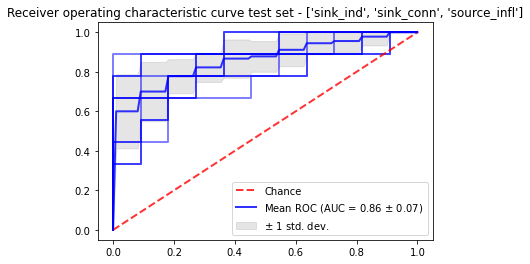

In [180]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set} set - {feature_set}",
)
ax.legend(loc="lower right")
plt.show()

## Plotting Predicted Probability of Success Scores

In [181]:
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    subjects = scores[f"{which_set}_subjects"][idx]
    for subject in subjects:
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        outcomes.append(outcome)

        center = meta_df[meta_df["patient_id"] == subject]["clinical_center"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(subjects)
    folds.extend([idx] * len(subjects))

In [182]:
proba_df = pd.DataFrame((y_probas, subj_list, outcomes, centers, folds)).T
proba_df.columns = ["y_proba", "subject", "outcome", "center", "fold"]

display(proba_df.head())

,y_proba,subject,outcome,center,fold
0,0.609425,PY19N023,S,jhu,0
1,0.335533,la16,F,cc,0
2,0.292,rns015,F,miami,0
3,0.653967,upmc3,F,upmc,0
4,0.551758,la21,S,cc,0


<AxesSubplot:xlabel='outcome', ylabel='y_proba'>

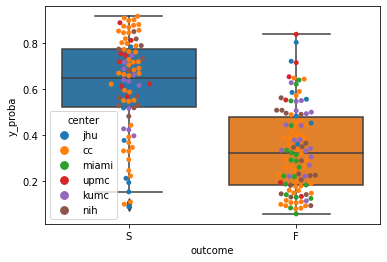

In [183]:
fig, ax = plt.subplots()
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(x="outcome", y="y_proba", data=proba_df, ax=ax)
sns.swarmplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)

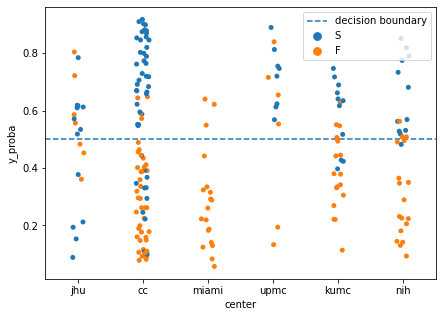

In [192]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.stripplot(x="center", y="y_proba", hue="outcome", data=proba_df, ax=ax)
ax.axhline([0.5], ls="--", label="decision boundary")
ax.legend()
# sns.boxplot(x="outcome", y="y_proba", hue="fold", data=proba_df, ax=ax)

## Plotting Calibration Curve

In [184]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

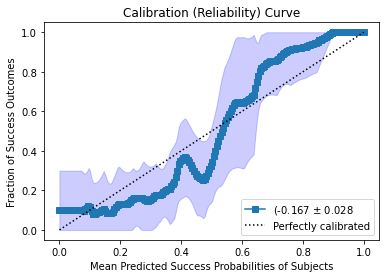

In [185]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots()
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"({np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)}",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Success Probabilities of Subjects",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right")
plt.show()